In [16]:
import numpy as np
import pandas as pd
import open3d
import os
import tqdm
import matplotlib.pyplot as plt
import utils.helpers as helpers
import utils.fread as fread
import utils.registration as registration
import copy

from utils.depth_camera import DepthCamera
from utils.config import Config

import utils.registration as registration
import utils.fread as fread
import utils.FCGF as FCGF
import utils.helpers as helpers

from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate

In [2]:
config = Config(
    sequence_dir="data/raw_data",
    feature_dir="data/features",
    output_dir="data/trajectories/estimated_imu+depth",
    experiment="exp_8",
    trial="trial_2",
    subject="subject-1",
    sequence="03",
    groundtruth_dir="data/trajectories/groundtruth",
)

config.voxel_size=0.03
config.target_fps=20
config.min_std=0.5

In [3]:
pose_file = os.path.join(config.get_groundtruth_dir(), f"{config.get_file_name()}.pose.npz")
motion_dir = config.get_motion_dir(include_secondary=False)

In [67]:
accel_df = pd.read_csv(os.path.join(motion_dir, "accel.csv"))
gyro_df = pd.read_csv(os.path.join(motion_dir, "gyro.csv"))

accel_df.drop_duplicates("timestamp", inplace=True)
gyro_df.drop_duplicates("timestamp", inplace=True)

gravity_df = pd.DataFrame(columns=["timestamp", "x", "y", "z"])

imu_df = pd.merge(accel_df, gyro_df, on="timestamp", suffixes=("a", "g"))

raw_accel_df = imu_df[["timestamp", "xa", "ya", "za"]].copy()

frame_rate = accel_df.shape[0] / (accel_df.timestamp.values[-1] - accel_df.timestamp.values[0]) * 1000

win_len = int(frame_rate * 4) # 4 seconds window

gravity = imu_df.iloc[:win_len, [1, 2, 3]].mean().values
# compute dt in seconds
imu_df.loc[:, "dt"] = np.concatenate([[0], (imu_df.timestamp.values[1:] - imu_df.timestamp.values[:-1]) / 1000])
# remove first row as the dt is 0
imu_df = imu_df.iloc[1:]
# reset index in pandas data frame
imu_df.reset_index(drop=True, inplace=True)

# Fill 0 for displacement, angles, and coordinates
imu_df.loc[:, "x"] = np.zeros(len(imu_df))
imu_df.loc[:, "y"] = np.zeros(len(imu_df))
imu_df.loc[:, "z"] = np.zeros(len(imu_df))

print(f"Frame rate: {frame_rate:.2f} Hz")
print(f"Window length: {win_len} frames")

Frame rate: 400.21 Hz
Window length: 1600 frames


In [68]:
# apply gaussian filter to smooth acceleration and gyro data
imu_df.loc[:, "xa"] = gaussian_filter1d(imu_df.xa.values, sigma=10)
imu_df.loc[:, "ya"] = gaussian_filter1d(imu_df.ya.values, sigma=10)
imu_df.loc[:, "za"] = gaussian_filter1d(imu_df.za.values, sigma=10)
imu_df.loc[:, "xg"] = gaussian_filter1d(imu_df.xg.values, sigma=10)
imu_df.loc[:, "yg"] = gaussian_filter1d(imu_df.yg.values, sigma=10)
imu_df.loc[:, "zg"] = gaussian_filter1d(imu_df.zg.values, sigma=10)

In [69]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)
velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    da = np.degrees([v[j + 4] * v[7] for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values
    gravity_rotated = np.dot(rotation_matrix, np.array([*gravity, 1]))
    acceleration = acceleration - gravity_rotated[:3]
    
    imu_df.iloc[i, 1] = acceleration[0]
    imu_df.iloc[i, 2] = acceleration[1]
    imu_df.iloc[i, 3] = acceleration[2]
    
    # rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

accel_mavg = imu_df[["xa", "ya", "za"]].rolling(window=win_len).mean()
accel_mavg.fillna(0, inplace=True)

imu_df[["xa", "ya", "za"]] = imu_df[["xa", "ya", "za"]] - accel_mavg

100%|██████████| 7999/7999 [00:02<00:00, 3281.79it/s]


In [70]:
imu_df = imu_df.iloc[win_len:]

In [ ]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(imu_df))):
    v = imu_df.iloc[i].values
    
    dt = v[7]
    
    # current displacement and rotation
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = imu_df.iloc[i, [1, 2, 3]].values

    d = [(velocity[j] * dt) + (0.5 * acceleration[j] * dt * dt) for j in range(3)]
    d = np.dot(rotation_matrix, np.array([*d, 1]))
    
    imu_df.iloc[i, 8] = imu_df.iloc[i - 1, 8] + d[0]
    imu_df.iloc[i, 9] = imu_df.iloc[i - 1, 9] + d[1]
    imu_df.iloc[i, 10] = imu_df.iloc[i - 1, 10] + d[2]
    
    velocity = [velocity[j] + acceleration[j] * dt for j in range(3)]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

In [7]:
sequence_ts = fread.get_timstamps_from_images(config.get_sequence_dir(include_secondary=False), ext=".depth.png")

depth_camera = DepthCamera("secondary", os.path.join(config.sequence_dir, config.experiment, "metadata", "device-0-aligned.json"))

poses = np.load(pose_file)
trajectory_t = poses["trajectory_t"]
local_t = poses["local_t"]

start_ind = 30 * 5
sequence_ts = sequence_ts[start_ind:]

In [8]:
local_pcds = []

for t in tqdm.trange(len(sequence_ts)):
    depth_img_file = os.path.join(config.get_sequence_dir(include_secondary=False), f"frame-{sequence_ts[t]}.depth.png")
    pcd = depth_camera.depth_to_point_cloud(depth_img_file)
    pcd = pcd.voxel_down_sample(voxel_size=0.03)
    local_pcds.append(pcd)

100%|██████████| 324/324 [00:10<00:00, 29.56it/s]


In [9]:
gt_xyz = trajectory_t[start_ind:, :3, 3]
gt_trajectory = helpers.make_pcd(gt_xyz)

In [ ]:
# open3d.visualization.draw_geometries([gt_trajectory])

First second is used to find the gravity vector

In [10]:
elapsed_time = (sequence_ts - sequence_ts[0]) // 1e3
calibration_ts = np.argwhere(elapsed_time == 0).flatten()

In [71]:
# velocity
velocity = np.diff(gt_xyz[calibration_ts], axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)
linear_acceleration = np.diff(velocity, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts][1:]).reshape(-1, 1)

In [72]:
calibration_imu_df = imu_df[(imu_df.timestamp >= sequence_ts[calibration_ts[2]]) & (imu_df.timestamp <= sequence_ts[calibration_ts[-1]])].copy()

In [73]:

linear_acceleration_interp = []
linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:], linear_acceleration[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:], linear_acceleration[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:], linear_acceleration[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

# linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:], linear_acceleration[:, 0], kind="linear")(calibration_imu_df.timestamp.values))
# linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:], linear_acceleration[:, 1], kind="linear")(calibration_imu_df.timestamp.values))
# linear_acceleration_interp.append(interpolate.interp1d(sequence_ts[calibration_ts][2:], linear_acceleration[:, 2], kind="linear")(calibration_imu_df.timestamp.values))

linear_acceleration_interp = np.array(linear_acceleration_interp)

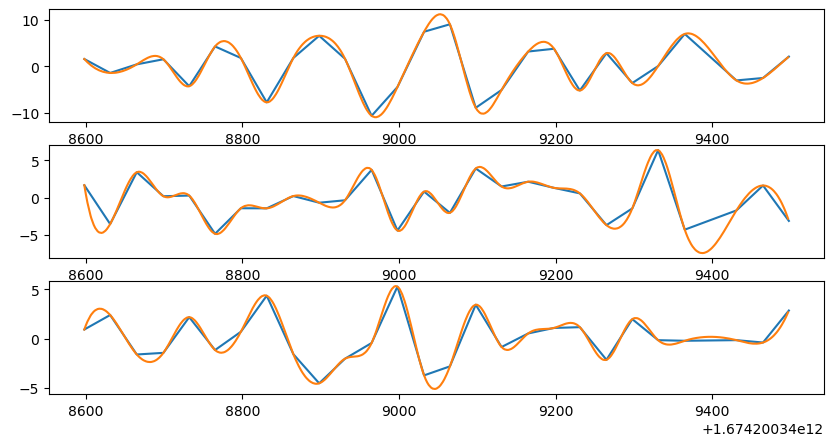

In [74]:
# plot linear acceleration and interpolated linear acceleration in subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 5))

axs[0].plot(sequence_ts[calibration_ts][2:], linear_acceleration[:, 0], label="Acceleration")
axs[0].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[0], label="Interpolated")


axs[1].plot(sequence_ts[calibration_ts][2:], linear_acceleration[:, 1], label="Acceleration")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[1], label="Interpolated")

axs[2].plot(sequence_ts[calibration_ts][2:], linear_acceleration[:, 2], label="Acceleration")
axs[2].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[2], label="Interpolated")

In [62]:
# calculate displacement and rotation
rotation_matrix = np.identity(4)

velocity = [0, 0, 0]

for i in tqdm.tqdm(range(1, len(calibration_imu_df))):
    v = calibration_imu_df.iloc[i].values
    
    dt = v[7]
    da = np.degrees([v[j + 4] * dt for j in range(3)])
    
    acceleration = calibration_imu_df.iloc[i, [1, 2, 3]].values
    acceleration = np.dot(rotation_matrix, np.array([*acceleration, 1]))
    acceleration = acceleration[:3]
    
    calibration_imu_df.iloc[i, 1] = acceleration[0]
    calibration_imu_df.iloc[i, 2] = acceleration[1]
    calibration_imu_df.iloc[i, 3] = acceleration[2]
    
    rotation_matrix = helpers.rotate_transformation_matrix(rotation_matrix, da[0], da[1], da[2])

100%|██████████| 363/363 [00:00<00:00, 3331.30it/s]


In [66]:
gravity = calibration_imu_df.iloc[:, [1, 2, 3]].values - linear_acceleration_interp.T
print(f"Gravity: {np.mean(np.linalg.norm(gravity, axis=1))}")

Gravity: 10.869574790298739


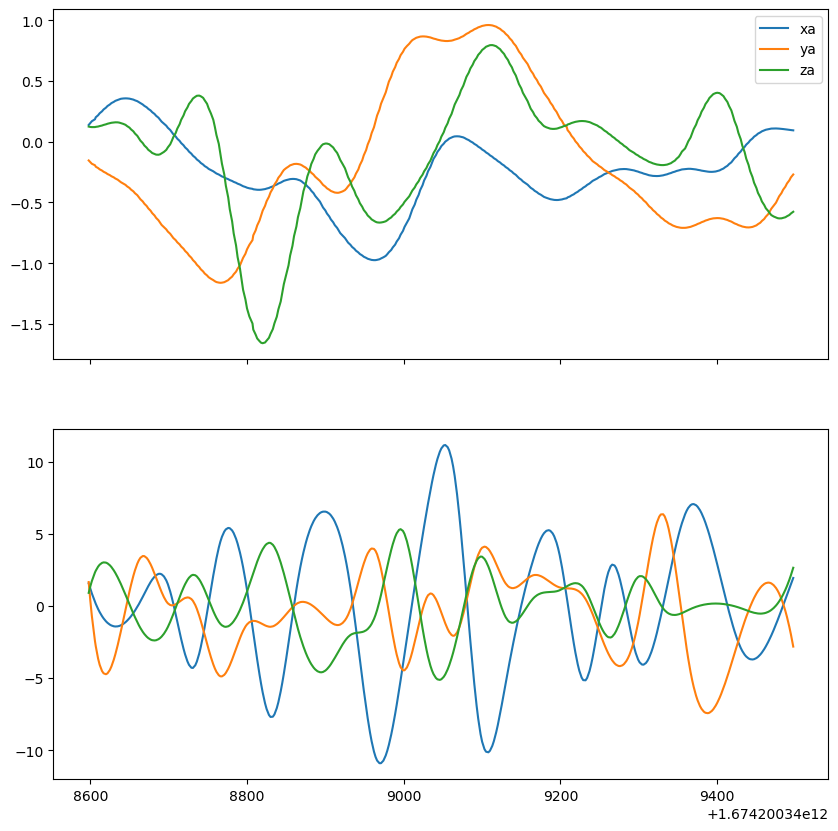

In [107]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

calibration_imu_df.plot(x="timestamp", y=["xa", "ya", "za"], ax=axs[0])

axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[0], label="x")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[1], label="y")
axs[1].plot(calibration_imu_df.timestamp.values, linear_acceleration_interp[2], label="z")

# axs[2].plot(calibration_imu_df.timestamp.values, gravity[:, 0], label="x")
# axs[2].plot(calibration_imu_df.timestamp.values, gravity[:, 1], label="y")
# axs[2].plot(calibration_imu_df.timestamp.values, gravity[:, 2], label="z")
# axs[2].plot(calibration_imu_df.timestamp.values, np.linalg.norm(gravity, axis=1), label="norm")

In [76]:
def rotation_matrix_to_euler_angles(R):
    sy = np.sqrt(R[0,0]**2 + R[1,0]**2)
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2,1], R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [77]:
rotation_matrices = trajectory_t[start_ind:, :3, :3][calibration_ts]

euler_angles = np.array([rotation_matrix_to_euler_angles(R) for R in rotation_matrices])
angular_velocity = np.diff(euler_angles, axis=0) * 1e3 / np.diff(sequence_ts[calibration_ts]).reshape(-1, 1)

resampled_angular_velocity = []
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 0], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 1], kind="cubic")(calibration_imu_df.timestamp.values))
resampled_angular_velocity.append(interpolate.interp1d(sequence_ts[calibration_ts][1:], angular_velocity[:, 2], kind="cubic")(calibration_imu_df.timestamp.values))

resampled_angular_velocity = np.array(resampled_angular_velocity).T

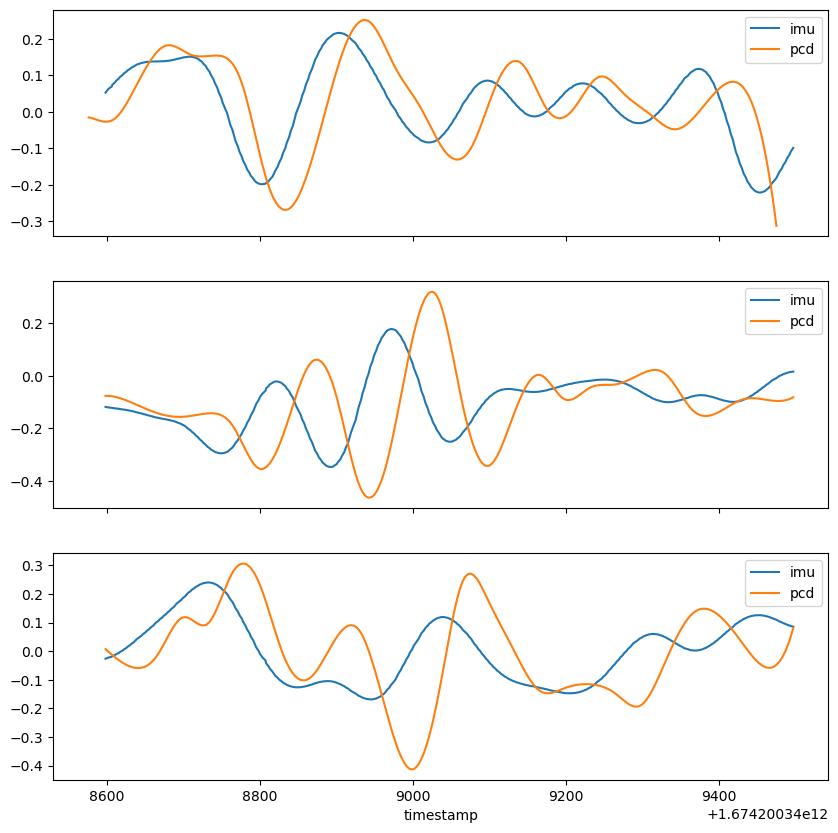

In [101]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

In [97]:
corr = np.correlate(calibration_imu_df.xg.values, resampled_angular_velocity[:, 0], mode='full')

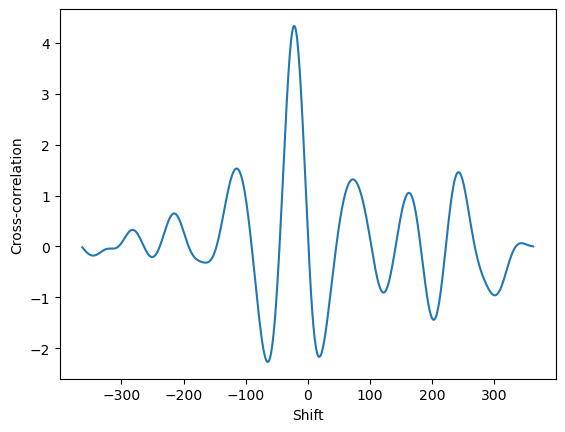

In [98]:
shifts = np.arange(-calibration_imu_df.shape[0] + 1, calibration_imu_df.shape[0])  # All possible shifts

plt.plot(shifts, corr)
plt.xlabel('Shift')
plt.ylabel('Cross-correlation')
plt.show()

In [106]:
delta = (np.argmax(corr) - calibration_imu_df.shape[0] + 1) * 1000 / frame_rate

print(f"Time shift: {delta} ms")

Time shift: -54.971128608923884 ms


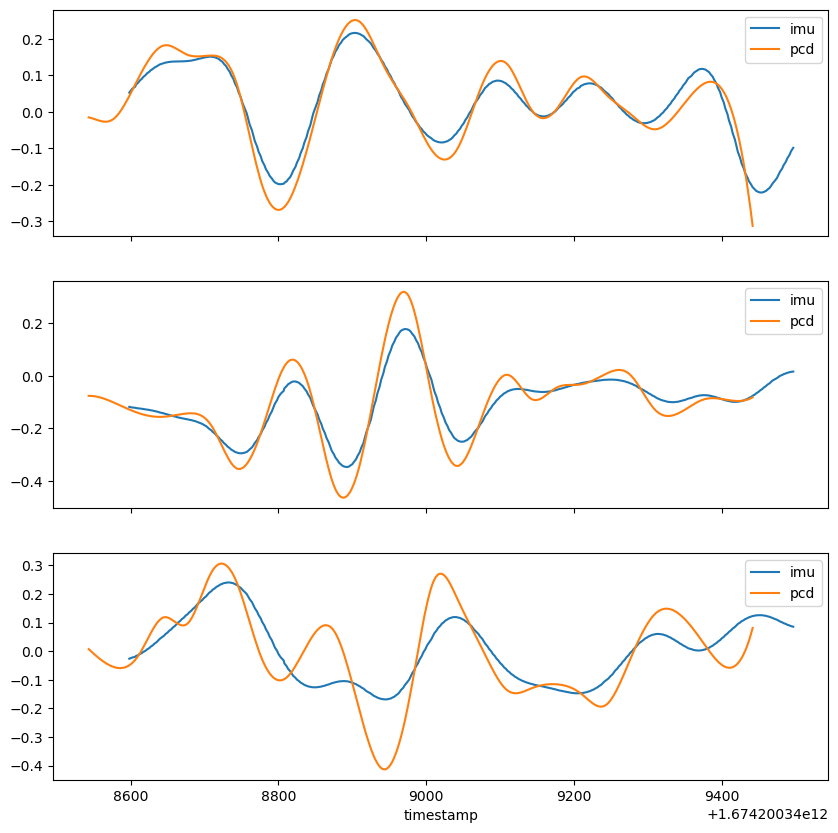

In [105]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

calibration_imu_df.plot(x="timestamp", y="xg", ax=axs[0], label="imu")
axs[0].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 0], label="pcd")
axs[0].legend()

calibration_imu_df.plot(x="timestamp", y="yg", ax=axs[1], label="imu")
axs[1].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 1], label="pcd")
axs[1].legend()

calibration_imu_df.plot(x="timestamp", y="zg", ax=axs[2], label="imu")
axs[2].plot(calibration_imu_df.timestamp.values + delta, resampled_angular_velocity[:, 2], label="pcd")
axs[2].legend()

In [ ]:
grav